In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import argparse

In [2]:
# Gaussian Kernel :
# Using 5x5 kernel 
x, y = np.meshgrid(np.linspace(-1,1,3), np.linspace(-1,1,3))
d = np.sqrt(x*x+y*y)
sigma, mu = 1.5, 0.0
g = np.exp(-( (d-mu)**2 / ( 1.0 * sigma**2 ) ) )
gauss_kernel = np.divide(g,np.sum(g))
print(gauss_kernel)

[[0.07892087 0.12308684 0.07892087]
 [0.12308684 0.19196914 0.12308684]
 [0.07892087 0.12308684 0.07892087]]


In [3]:
# Pair 1 :Dog vs Wig:  Size- 909, 700
testimg1 = cv2.imread('dog_back.png',cv2.IMREAD_GRAYSCALE)
print("Size of dog back ", testimg1.shape)
testimg2 = cv2.imread('dog_fore.png',cv2.IMREAD_GRAYSCALE)
print("Size of dog fore: ", testimg2.shape)

# Pair 2 : Sunflower vs Donald duck- Size- 464, 696
testimg3 = cv2.imread('sunflower.png',cv2.IMREAD_GRAYSCALE)
print("Size of sunflower bg: ", testimg3.shape)
testimg4 = cv2.imread('sun_fore2.png',cv2.IMREAD_GRAYSCALE)
print("Size of sunflower fg: ", testimg4.shape)

# Pair 3: Obama vs Aaron - Size - 550, 1150
testimg5 = cv2.imread('obama_1.png',cv2.IMREAD_GRAYSCALE)
print("Size of obama bg: ", testimg5.shape)
testimg6 = cv2.imread('obama_fore1.png',cv2.IMREAD_GRAYSCALE)
print("Size of obama fg: ", testimg6.shape)


Size of dog back  (909, 700)
Size of dog fore:  (909, 700)
Size of sunflower bg:  (464, 696)
Size of sunflower fg:  (464, 696)
Size of obama bg:  (550, 1150)
Size of obama fg:  (550, 1150)


In [4]:
#Zero Padding the image
def zero_padding(img_pad,ks):
    kr, kc = ks.shape
    rows, cols = img_pad.shape
    
    #To calculate how many rows or columns to add : eg for 3x3 kernel we will add 2 rows and 2 columns
    rows_pad = rows + kr - 1
    cols_pad = cols + kc -1
    
    img_zero = np.zeros((rows_pad,cols_pad))
    
    #loop to add zeros to the new rows and columns
    for i in range(rows):
        for j in range(cols):
            img_zero[i+np.int32((kr-1)/2),j+np.int32((kc-1)/2)] = img_pad[i,j]
    return img_zero

In [5]:
#Function to implement convolution: Arguments passed are the image, kernel and padding
def conv_padding(img1,w):
    
    #img2 = zero_padding(img1,w)
    rows, cols = img1.shape
    pad = zero_padding(img1,w)
    rows1, cols1 = pad.shape
    rows_k , cols_k = w.shape
    #print(rows, cols)
    conv_img = np.zeros((rows,cols))
    k = 0
    l = 0
    #loop which iterates through all rows and columns of image
    for i in range(0,rows):
        for j in range(0,cols):
            
            sum = 0
        
        #loop which iterates through the kernel and the corresponding pixel of image to perform convolution
            for k in range(rows_k):
                for l in range(cols_k):
                    
                    sum =  sum + np.round((np.multiply(w[k,l],pad[i+k,j+l])))
                    
                    
                         
            conv_img[i][j] = sum
                    
    return conv_img

In [6]:
def ComputePyr(img,n):
    
# Taking the image as an input : Gray Image
    gauss_new_img = img
    
    gaussian_pyramid_arr = [gauss_new_img]
    
# Loop to compute the gaussian pyramid based on number of layers

    for i in range(n):
        
# Performing image smoothning with gaussian filter
        gauss_new_img = conv_padding(gauss_new_img,gauss_kernel)
    
        rows_down, cols_down = gauss_new_img.shape
    
        dim_rows_down = math.ceil(rows_down/2) 
        dim_cols_down = math.ceil(cols_down/2)
    
        dim_down = (dim_rows_down,dim_cols_down)
        
# Performing downsampling to the smoothened image
        new_dim_down = cv2.resize(gauss_new_img,dim_down, interpolation= cv2.INTER_NEAREST)
        
        gauss_new_img = np.copy(new_dim_down)
        
# An array that contains all the gaussian layers   
        gaussian_pyramid_arr.append(gauss_new_img)
    
        #print(str(i),gaussian_pyramid_arr[i].shape)
    
# Now computing the Laplacian Pyramid
    laplacian_pyramid_arr = []
    
    for j in range(n):
        
# Smoothing the (N+1) Gaussian Layer to compute the N New-Layer
        lap_new_img = conv_padding(gaussian_pyramid_arr[j+1],gauss_kernel)
        size = (gaussian_pyramid_arr[j].shape[1],gaussian_pyramid_arr[j].shape[0])
# Upsampling the Smoothened image
        dim_upsample = cv2.resize(lap_new_img,size)
        lap_new_img = np.copy(dim_upsample)
# Taking the difference of the Nth Gaussian Layer and Nth New-Layer to compute the Nth Laplacian Layer
        laplacian_compute = np.subtract(gaussian_pyramid_arr[j],dim_upsample)

        laplacian_pyramid_arr.append(laplacian_compute)
    
    laplacian_pyramid_arr.append(gaussian_pyramid_arr[n])
        
          

    return gaussian_pyramid_arr , laplacian_pyramid_arr
        

In [7]:
def gaussian_pyr(img,n):
    
    gauss_new_img = img
    
    gaussian_pyramid_arr = [gauss_new_img]
    
    for i in range(n):
        
        gauss_new_img = conv_padding(gauss_new_img,gauss_kernel)
    
        rows_down, cols_down = gauss_new_img.shape
    
        dim_rows_down = math.ceil(rows_down/2) 
        dim_cols_down = math.ceil(cols_down/2)
    
        dim_down = (dim_rows_down,dim_cols_down)
        new_dim_down = cv2.resize(gauss_new_img,dim_down, interpolation= cv2.INTER_NEAREST)
        
        gauss_new_img = np.copy(new_dim_down)
    
        gaussian_pyramid_arr.append(gauss_new_img)
        #cv2.imshow(str(i),gaussian_pyramid_arr[i]/255)
        
    cv2.waitKey(0)
    return gaussian_pyramid_arr

In [8]:
# function to calculate maximum layers that can be computed
def calculate_num_layers(img3,k1):
    rows3,cols3 = img3.shape
    rowsk,colsk = k1.shape
    resized_image = img3
    count = 0
    while rows3 >= rowsk and cols3 >= colsk:
        
        count = count + 1
        rows3 =  np.round(rows3/2) 
        cols3 = np.round(cols3/2)
        
    return count
        

In [9]:
num_layers = calculate_num_layers(testimg5,gauss_kernel)
print(num_layers)

8


In [10]:
# Setting pair images 
# Setting background image
gauss_new_img1 = testimg3
temp = gauss_new_img1 
gPyr, lPyr = ComputePyr(gauss_new_img1,num_layers)
 
# Setting foreground image
image2 = testimg4
gPyr2 , lPyr2 = ComputePyr(image2,num_layers)

# Setting image for mask
img_mask = testimg4

In [11]:
# This GUI will first pop-out the foreground image and ask to grad the mouse over the ROI and then will pop up the confirmed region
test_rows, test_cols = img_mask.shape
test_img = np.zeros((test_rows,test_cols))
#img2 = cv2.imread("flower.jpg")

# variables
ix = -1
iy = -1
drawing = False

def draw_reactangle_with_drag(event, x, y, flags, param):
    global ix, iy, drawing, img
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix = x
        iy = y


    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            #img2 = cv2.imread("flower.jpg")
            img2 = img_mask 
            cv2.rectangle(img2, pt1=(ix,iy), pt2=(x, y),color=(255,255,255),thickness=10)
            cv2.rectangle(test_img, pt1=(ix,iy), pt2=(x, y),color=(255,255,255),thickness=10)
            img = img2

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        #img2 = cv2.imread("flower.jpg")
        img2 = img_mask 
        cv2.rectangle(img2, pt1=(ix,iy), pt2=(x, y),color=(255,255,255),thickness=10)
        cv2.rectangle(test_img, pt1=(ix,iy), pt2=(x, y),color=(255,255,255),thickness=10)
        img = img2
        
cv2.namedWindow(winname= "Draw the mouse to make a rectange")
cv2.setMouseCallback("Draw the mouse to make a rectange", draw_reactangle_with_drag)

while True:
    cv2.imshow("Draw the mouse to make a rectange", img_mask)
    if cv2.waitKey(0):
        break
cv2.destroyAllWindows()

# cv2.imshow("BW",test_img)
mask_gray = test_img/255
cv2.imshow("BW",mask_gray)
cv2.waitKey(0)




-1

In [12]:
# Computing Gaussian Pyramid of the mask image
mask_gauss = gaussian_pyr(mask_gray,num_layers)


In [13]:
# Function to blending two images by using the formula
def image_blend(lap1,lap2,mask):
    
    blend_img = []
    
    for la,lb,mask1 in zip(lap1,lap2,mask):
        
        #blend = np.add(np.multiply(mask,la),np.multiply(np.subtract(1.0,mask),lb))
        blend = mask1 * lb + (1.0 - mask1) * la
        blend_img.append(blend)
    return blend_img

In [14]:
add_lap = image_blend(lPyr,lPyr2,mask_gauss)


In [15]:
def image_reconstruct(add_lap_arr,n):
    
    res_img = []
    add_lap_arr.reverse()
    res_img.append(add_lap_arr[0])
    
    laplacian_pyramid_arr = []
    
    lap_top = add_lap_arr[0].astype('float32')
    lap_expand = np.copy(lap_top)
# Iterating from bottom layer (8x8) to top most layer (512x512)   
    for j in range(n):
    
        size = (add_lap_arr[j+1].shape[1],add_lap_arr[j+1].shape[0])
# Upsampling the Smoothened image
        
        lap_top = cv2.resize(lap_top,size)
        
        lap_expand = conv_padding(lap_top,gauss_kernel)
        #lena_expand = cv2.GaussianBlur(lap_top, (3,3), 0)
        lap_top = np.copy(lap_expand)
# Taking the difference of the Nth Gaussian Layer and Nth New-Layer to compute the Nth Laplacian Layer
        laplacian_compute = np.add(add_lap_arr[j+1],lap_expand)
        print(laplacian_compute.shape)

        res_img.append(laplacian_compute)
    
    return res_img

(6, 4)
(8, 11)
(22, 15)
(29, 44)
(87, 58)
(116, 174)
(348, 232)
(464, 696)


-1

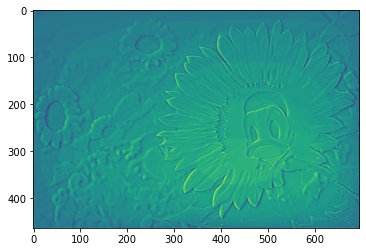

In [16]:
final = image_reconstruct(add_lap,num_layers)
plt.imshow(final[num_layers])
cv2.imshow("Reconstruct",final[num_layers]/255)
cv2.waitKey(0)

In [17]:
# cv2.imshow("reconstruct.png",final[7]/255)
# cv2.waitKey(0)